In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [114]:
# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
data = pd.read_csv('creditcard.csv')
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data = data.drop(['Time'], axis=1)

dataset = data.to_numpy().astype(np.float32)

X = dataset[:, :-1]
y = dataset[:, -1]

In [115]:
# Split entire dataset into train and test
data_train, data_test, label_train, label_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
# -----------------------------
# 3. Define the Autoencoder Model
# -----------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: 30 -> 23 -> 19 -> 17 -> 8
        self.encoder = nn.Sequential(
            nn.Linear(29, 23),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(23, 19),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(19, 17),
            nn.Tanh(),
            nn.Linear(17, 8)
        )
        # Decoder: 8 -> 17 -> 19 -> 23 -> 30 with Sigmoid at the end
        # (Sigmoid is optional if you are using MSELoss and inputs are not strictly [0,1])
        self.decoder = nn.Sequential(
            nn.Linear(8, 17),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(17, 19),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(19, 23),
            nn.LeakyReLU(0.2),
            nn.Linear(23, 29)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

(284, 29)
Epoch 0, Train Loss: 25.3880, Val Loss: 29.0207
Epoch 50, Train Loss: 7.3405, Val Loss: 7.0696
Epoch 100, Train Loss: 6.7362, Val Loss: 6.8292
Epoch 150, Train Loss: 6.4110, Val Loss: 6.7336
Epoch 200, Train Loss: 6.2936, Val Loss: 6.5576
Epoch 250, Train Loss: 6.1706, Val Loss: 6.4071
Epoch 300, Train Loss: 5.8542, Val Loss: 6.2605
Epoch 350, Train Loss: 5.7881, Val Loss: 6.3137
Epoch 400, Train Loss: 5.7105, Val Loss: 6.2016
Epoch 450, Train Loss: 5.7043, Val Loss: 6.1330
Epoch 500, Train Loss: 5.3517, Val Loss: 5.9737
Epoch 550, Train Loss: 5.5149, Val Loss: 5.7466
Epoch 600, Train Loss: 5.3308, Val Loss: 5.5724
Epoch 650, Train Loss: 5.2661, Val Loss: 5.3535
Epoch 700, Train Loss: 5.1399, Val Loss: 5.1573
Epoch 750, Train Loss: 4.9817, Val Loss: 5.0036
Epoch 800, Train Loss: 5.1140, Val Loss: 4.9663
Epoch 850, Train Loss: 4.9202, Val Loss: 4.9734
Epoch 900, Train Loss: 4.9181, Val Loss: 4.9426
Epoch 950, Train Loss: 4.8623, Val Loss: 4.8828
Epoch 1000, Train Loss: 4.9081,

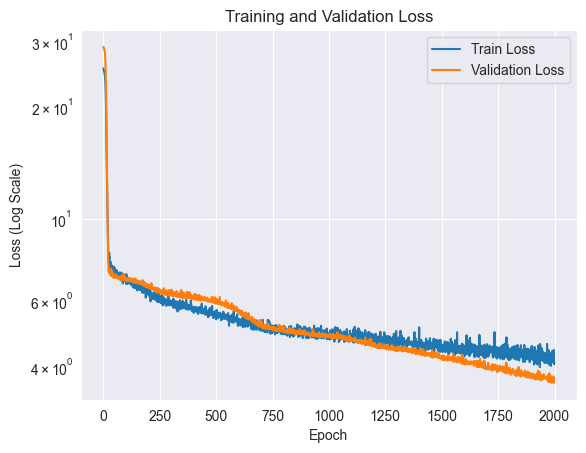

In [117]:
# -----------------------------
# 1. Extract fraud samples using label_train (1 = fraud)
# -----------------------------
# data_train and label_train are assumed to be already defined from your previous splitting.
data_train_fraud = data_train[label_train == 1]

# -----------------------------
# 2. Train/Validation Split (80-20) on the fraud samples
# -----------------------------
data_train_autoencoder, test_data_autoencoder = train_test_split(data_train_fraud, test_size=0.2, random_state=32)

print(data_train_autoencoder.shape)
# Convert numpy arrays to PyTorch tensors (ensure float type)
tensor_fraud_train = torch.from_numpy(data_train_autoencoder).float()
tensor_fraud_val   = torch.from_numpy(test_data_autoencoder).float()

# For an autoencoder, input equals target
train_dataset = TensorDataset(tensor_fraud_train, tensor_fraud_train)
val_dataset   = TensorDataset(tensor_fraud_val, tensor_fraud_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# -----------------------------
# 4. Initialize Model, Loss, Optimizer, and Scheduler
# -----------------------------
my_autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()  # Using MSELoss now
optimizer = optim.Adam(my_autoencoder.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-6)

# -----------------------------
# 5. Training Loop with L1 Regularization and Validation Evaluation
# -----------------------------
num_epochs = 2000
history_loss_train = []
history_loss_val   = []
patience = 75
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

l1_lambda = 5e-3  # L1 regularization strength

for epoch in range(num_epochs):
    my_autoencoder.train()
    running_loss_train = 0.0
    for batch_x, _ in train_loader:
        inputs = batch_x.to(device)
        optimizer.zero_grad()
        outputs = my_autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        # Compute L1 norm of the model parameters
        l1_norm = sum(p.abs().sum() for p in my_autoencoder.parameters())
        loss = loss + l1_lambda * l1_norm
        
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * inputs.size(0)
    
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    history_loss_train.append(epoch_loss_train)

    # --- Validation Phase ---
    my_autoencoder.eval()
    running_loss_val = 0.0
    with torch.no_grad():
        for batch_x, _ in val_loader:
            inputs = batch_x.to(device)
            outputs = my_autoencoder(inputs)
            loss = criterion(outputs, inputs)
            running_loss_val += loss.item() * inputs.size(0)
    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    history_loss_val.append(epoch_loss_val)

    # Early stopping check
    if epoch_loss_val < best_val_loss:
        best_val_loss = epoch_loss_val
        best_model_state = my_autoencoder.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        my_autoencoder.load_state_dict(best_model_state)
        break

    # Optionally step the scheduler
    # scheduler.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}")

# Save the model
torch.save(my_autoencoder.state_dict(), "autoencoder.pth")

# -----------------------------
# 6. Plot Training & Validation Loss
# -----------------------------
plt.figure()
plt.plot(history_loss_train, label='Train Loss')
plt.plot(history_loss_val, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (Log Scale)")
plt.title("Training and Validation Loss")
plt.yscale('log')
plt.legend()
plt.show()


In [118]:
# create the balanced dataset to train the SVM model
data_train_non_fraud = data_train[label_train == 0][:len(data_train_fraud)]

# Combine the selected data
X_balanced_SVM = np.vstack((data_train_non_fraud, data_train_fraud))
y_balanced_SVM = np.hstack((np.zeros(len(data_train_fraud)), np.ones(len(data_train_fraud))))  # Create labels: 0 for non-fraud, 1 for fraud

# Shuffle the data
shuffle_idx = np.random.permutation(len(X_balanced_SVM))
X_balanced_SVM = X_balanced_SVM[shuffle_idx]
y_balanced_SVM = y_balanced_SVM[shuffle_idx]

# Split into training and test sets for SVM
data_train_SVM, data_test_SVM, label_train_SVM, label_test_SVM = train_test_split(X_balanced_SVM, y_balanced_SVM, test_size=0.2, random_state=42)

# Train SVM model for validation in the oversampling process
my_svm = SVC(kernel='linear', C=1.0)
my_svm.fit(data_train_SVM, label_train_SVM)

# Get predictions and accuracy
label_pred_test = my_svm.predict(data_test_SVM)
label_pred_train = my_svm.predict(data_train_SVM)
accuracy_train = np.mean(label_pred_train == label_train_SVM)
accuracy_test = np.mean(label_pred_test == label_test_SVM)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Train Accuracy: 0.9490
Test Accuracy: 0.9301


In [104]:
def get_fraud_indices(labels):
    """Return indices for which label == 1."""
    return np.where(labels == 1)[0]

def get_legit_indices(labels):
    """Return indices for which label == 0."""
    return np.where(labels == 0)[0]

# Example: placeholders for data_train, y_train
# data_train = np.random.randn(100, 30)
# y_train    = np.random.randint(0, 2, size=100)

# Make your copies to oversample
oversampled_data = data_train.copy()
oversampled_labels = label_train.copy()

# For oversampling, we want to add synthetic fraud samples until fraud count equals non-fraud count.
non_fraud_count = np.sum(oversampled_labels == 0)
fraud_count = np.sum(oversampled_labels == 1)
print(f"Initial counts - Fraud: {fraud_count}, Non-fraud: {non_fraud_count}")

# Number of synthetic samples to generate per iteration and noise std
n_samples_per_iter = 300

# Use only the original fraud samples (from the training set) as the basis for synthetic data generation.
original_fraud_data = data_train[label_train == 1]
original_fraud_data_tensor = torch.tensor(original_fraud_data, dtype=torch.float32)

# Ensure the autoencoder is in evaluation mode
my_autoencoder.eval()

alpha = 0.9

while len(get_fraud_indices(oversampled_labels)) < len(get_legit_indices(oversampled_labels)):
    fraud_indices = get_fraud_indices(oversampled_labels)
    legit_count = len(get_legit_indices(oversampled_labels))
    fraud_count = len(fraud_indices)
    remaining_needed = legit_count - fraud_count

    if fraud_count == 0:
        print("No fraud data found. Cannot proceed with oversampling.")
        break

    # 1) Gather all fraud samples
    fraud_only_X = oversampled_data[fraud_indices, :]
    fraud_data_tensor = torch.tensor(fraud_only_X, dtype=torch.float32)

    # 2) Encode to latent space
    #latent_representations = my_autoencoder.encoder(fraud_data_tensor)
    #n = len(latent_representations)
    #if n == 0:
    #    print("Error: no latent representations. Check input data.")
    #    break

    # 3) Interpolate in latent space + add noise
    #noisy_vectors = []
    #for _ in range(300):  # You can reduce this if too many are generated
    #    i = np.random.randint(0, n)
    #    j = np.random.randint(0, n)

    #    z_i = latent_representations[i]
    #    z_j = latent_representations[j]

    #    lambda_ = np.random.rand()
    #    z_ij = lambda_ * z_i + (1 - lambda_) * z_j

    #    noise = torch.normal(mean=0.0, std=alpha, size=z_ij.shape)
    #    z_syn = z_ij + noise

    #   noisy_vectors.append(z_syn.detach().cpu().numpy())

    # noisy_vectors = np.array(noisy_vectors)
    
    #latent_reps = np.array(latent_representations.detach().cpu().numpy())
    # 4) Decode to original 30-dim space
    #X_synthetic = my_autoencoder.decoder(    torch.tensor(latent_reps, dtype=torch.float32)).detach().cpu().numpy()
    
    my_autoencoder.eval()
    with torch.no_grad():
        X_synthetic = my_autoencoder(original_fraud_data_tensor)
    # 5) Classify with SVM
    y_pred = my_svm.predict(X_synthetic)

    # 6) Keep only predicted fraud
    synthetic_fraud_mask = (y_pred == 1)
    X_synthetic_fraud = X_synthetic[synthetic_fraud_mask]
    y_synthetic_fraud = y_pred[synthetic_fraud_mask]

    # 7) Limit the number of fraud samples added to only what is needed
    max_add = min(len(X_synthetic_fraud), remaining_needed)
    if max_add <= 0:
        break  # done

    oversampled_data = np.vstack((oversampled_data, X_synthetic_fraud[:max_add]))
    oversampled_labels = np.hstack((oversampled_labels, y_synthetic_fraud[:max_add]))

    n_fraud = len(get_fraud_indices(oversampled_labels))
    n_legit = len(get_legit_indices(oversampled_labels))
    print(f"Added {max_add} synthetic fraud samples")
    print(f"Fraud / Legit count: {n_fraud} / {n_legit}")

print("\nFinal shape of data:", oversampled_data.shape)
print("Final # Fraud:", len(get_fraud_indices(oversampled_labels)))
print("Final # Legit:", len(get_legit_indices(oversampled_labels)))

# Save the balanced data
np.save("data_train_balanced.npy", oversampled_data)
np.save("y_train_balanced.npy", oversampled_labels)

Initial counts - Fraud: 356, Non-fraud: 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 711 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 1066 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 1421 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 1776 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 2131 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 2486 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 2841 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 3196 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 3551 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 3906 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 4261 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 4616 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 4971 / 199008
Added 355 synthetic fraud samples
Fraud / Legit count: 53

In [119]:
#from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE

#borderlineSMOTE = BorderlineSMOTE(random_state=42)

#X_train_with_smote, y_train_with_smote = borderlineSMOTE.fit_resample(data_train, label_train)

#print(X_train_with_smote.shape)

(398016, 29)


In [120]:

from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
import tensorflow as tf
from tensorflow.keras.models import Model

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=tf.squeeze(tf.tanh(tf.linalg.matmul(x,self.W)+self.b),axis=-1)
        at=tf.nn.softmax(et)
        at=tf.expand_dims(at,axis=-1)
        output=x*at
        return tf.reduce_sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

def create_ALSTM_model():
    inputs1=Input((1,29))
    att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
    att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
    att_out=attention()(att_in_1)
    outputs1=Dense(1,activation='sigmoid',trainable=True)(att_out)
    model1=Model(inputs1,outputs1)
    
    model1.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model1

In [121]:
from scipy.optimize import minimize_scalar

# --- Adjusted training function using Keras without a validation dataset ---
def train_model(model, X, y, num_epochs=2, batch_size=128):
    # Ensure X has shape (num_samples, 1, 30)
    if X.ndim == 2:
        X_train = X.reshape(-1, 1, X.shape[1])
    else:
        X_train = X

    # Train the model using Keras' fit without validation monitoring
    history = model.fit(X_train, y, epochs=num_epochs, batch_size=batch_size, verbose=1)
    return model

def GB_classifier(X, y, n_estimators=10):
    estimators = []
    
    # Define squared-error loss (for evaluating the ensemble)
    loss_fn = lambda y_true, y_pred: 0.5 * np.sum((y_true - y_pred)**2)
    
    # Initialize ensemble predictions for training data
    hx = np.full(len(y), 0, dtype=np.float32)
    
    for t in range(n_estimators):
        # Compute training residuals: true labels minus current ensemble predictions
        residuals = y - hx
        
        # Create a new instance of the Keras ALSTM model
        model_t = create_ALSTM_model()
        
        # Train the model on (X, residuals)
        train_model(model_t, X, residuals, num_epochs=2, batch_size=128)
        
        # Predict the current weak learner's output h_t on the training set.
        X_input = X.reshape(-1, 1, X.shape[1]) if X.ndim == 2 else X
        predictions = model_t.predict(X_input)
        h_t = predictions.flatten()
        
        # Use line search to determine the optimal step length alpha
        func = lambda alpha: np.sum(loss_fn(y, hx + alpha * h_t))
        alpha_t = np.float32(minimize_scalar(func, method="golden").x)
        
        # Update the ensemble predictions for training data
        hx += alpha_t * h_t
        
        print(f"a_{t+1} = {alpha_t:.4f}")
        print(f"hx_{t+1} = {hx}")
        
        estimators.append((model_t, alpha_t))
    
    return estimators

In [123]:
estimators = GB_classifier(oversampled_data, oversampled_labels, n_estimators=6)
# estimators = GB_classifier(X_train_with_smote, y_train_with_smote, n_estimators=6)

Epoch 1/2
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9685 - loss: 0.0334
Epoch 2/2
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9947 - loss: 0.0043
12438/12438 ━━━━━━━━━━━━━━━━━━━━ 5s 400us/step
a_1 = 0.9972
hx_1 = [5.9842019e-05 5.1020768e-05 2.8736888e-05 ... 9.9621743e-01 9.9661422e-01
 9.9697542e-01]
Epoch 1/2
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0233
Epoch 2/2
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0018
12438/12438 ━━━━━━━━━━━━━━━━━━━━ 5s 399us/step
a_2 = -1.7912
hx_2 = [-1.16668714e-04  3.81739446e-05 -1.59533101e-05 ...  9.96213198e-01
  9.96607482e-01  9.96973336e-01]
Epoch 1/2
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0234
Epoch 2/2
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0018
12438/12438 ━━━━━━━━━━━━━━━━━━━━ 6s 436us/step
a_3 = -0.2403
hx_3 = [-1.6145178e-04  3.2690055e-05 -3.2662305e-05 ...  9.9621171e-01

In [124]:
# Assuming data_test and label_test are defined from your earlier train_test_split
# Ensure data_test has shape (n_samples, 1, 30) if needed by the model
if data_test.ndim == 2:
    data_test_input = data_test.reshape(-1, 1, data_test.shape[1])
else:
    data_test_input = data_test

hx = np.full(len(data_test_input), 0, dtype=np.float32)

# Go through each model in the trained ensemble
for model, alpha in estimators:
    prediction = model.predict(data_test_input).flatten()
    hx += alpha * prediction

# Threshold the accumulated predictions to get binary outputs
y_pred_binary = np.where(hx > 0.5, 1, 0)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

precision = precision_score(label_test, y_pred_binary)
recall = recall_score(label_test, y_pred_binary)
f1 = f1_score(label_test, y_pred_binary)
accuracy = accuracy_score(label_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 487us/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 474us/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step
Precision: 0.2531
Recall: 0.8971
F1 Score: 0.3948
Accuracy: 0.9956


Confusion Matrix:
[[84947   360]
 [   14   122]]


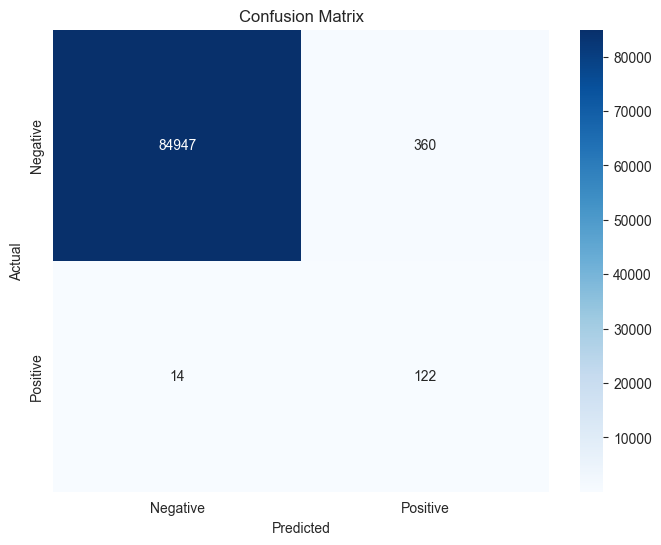

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Add after your existing metrics
cm = confusion_matrix(label_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [126]:
# (TP) shows how many fraud samples were successfully categorized.
TP = np.sum((label_test == 1) & (y_pred_binary == 1))
# (FP) refers to the number of legitimate samples that were incorrectly categorized.
FP = np.sum((label_test == 0) & (y_pred_binary == 1))
# (FN) shows how many fraud samples were missed.
FN = np.sum((label_test == 1) & (y_pred_binary == 0))
# (TN) refers to the number of legitimate samples that were correctly categorized.
TN = np.sum((label_test == 0) & (y_pred_binary == 0))

# Calculate the metrics
accuracy = (TP + TN) / (TP + FP + FN + TN)
specificity = TP / (FN + TP)
precision = TP / (FP + TP)
recall = TN / (TN + FP)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9956
Specificity: 0.8971
Precision: 0.2531
Recall: 0.9958
F1 Score: 0.4036
